## Introduction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
from sqlalchemy import create_engine
import sqlite3

Netflix every week does a top 10 of the most watched shows and films that week, we can get data on these rankings from netflix's own website: https://www.netflix.com/tudum/top10/ in the form of a .csv table or a excel sheet. I will use only the data from the global rankings, but data is available for multiple countries. You can check their methodology in more detail on their website.

In [2]:
all_weeks_global=pd.read_excel('data/all-weeks-global.xlsx')
all_weeks_global.head()

,week,category,weekly_rank,show_title,season_title,weekly_hours_viewed,runtime,weekly_views,cumulative_weeks_in_top_10,is_staggered_launch,episode_launch_details
0,2023-11-19,Films (English),1,The Killer,NaN,44500000,2.0000,22300000.0,2,False,NaN
1,2023-11-19,Films (English),2,Best. Christmas. Ever!,NaN,22300000,1.3667,16300000.0,1,False,NaN
2,2023-11-19,Films (English),3,Monster Hunter,NaN,10500000,1.7167,6100000.0,1,False,NaN
3,2023-11-19,Films (English),4,Locked In,NaN,8200000,1.6167,5100000.0,3,False,NaN
4,2023-11-19,Films (English),5,F9: The Fast Saga,NaN,10200000,2.3833,4300000.0,4,False,NaN


Netflix does 4 kinds of top 10 each week, they are: Films (English), Films (Non-English), TV (English), TV (Non-English). This dataset contains information on all 4 of them, and the column 'category' tells us in which of these categories each show falls in.

In [3]:
print(set(all_weeks_global['category'].values))

{'TV (Non-English)', 'TV (English)', 'Films (Non-English)', 'Films (English)'}


Let's see how they compare in terms of weekly hours viewed.

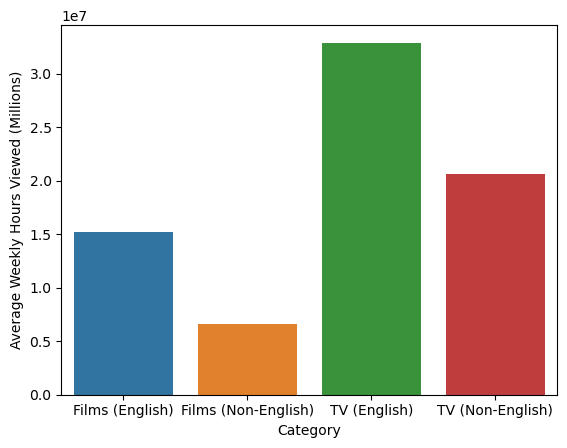

In [4]:
df=all_weeks_global.copy()

categories=df['category'].unique()
avg_weekly_hours_viewed_by_category=[]
for category in categories: # iterate on every category
    avg_hours=df.loc[df['category']==category]['weekly_hours_viewed'].mean() # get the average weekly hours viewed
    avg_weekly_hours_viewed_by_category.append(avg_hours)
    
ax=sns.barplot(x=categories,y=avg_weekly_hours_viewed_by_category) # do a bar plot
ax.set(xlabel='Category', ylabel='Average Weekly Hours Viewed (Millions)')
plt.show()

We can see that the TV (English) weekly top10 has on average way more hours viewed than the other categories. This is mostly due to the runtime of TV Shows compared to Films.

In [5]:
ratio=avg_weekly_hours_viewed_by_category[2]/np.sum(avg_weekly_hours_viewed_by_category)
print(f'More precisely TV (English) represents around {round(ratio*100,2)}% of the total hours viewed weekly on average, by titles on the weekly \ntop10.')

More precisely TV (English) represents around 43.68% of the total hours viewed weekly on average, by titles on the weekly 
top10.


This is mostly due to the runtime of TV Shows compared to Films

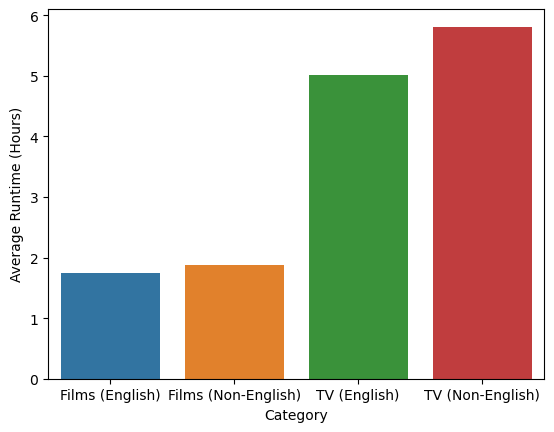

In [6]:
df=all_weeks_global.copy()

categories=df['category'].unique()
avg_runtime_by_category=[]
for category in categories: # iterate on every category
    avg_runtime=df.loc[df['category']==category]['runtime'].mean() # get the average runtime
    avg_runtime_by_category.append(avg_runtime)
    
ax=sns.barplot(x=categories,y=avg_runtime_by_category) # do a bar plot
ax.set(xlabel='Category', ylabel='Average Runtime (Hours)')
plt.show()

In fact, if we compare the views (hours viewed divided by runtime) instead of hours viewed:

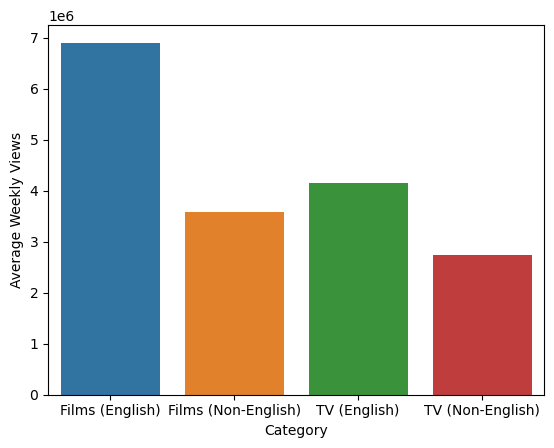

In [7]:
df=all_weeks_global.copy()

categories=df['category'].unique()
avg_weekly_views_by_category=[]
for category in categories: # iterate on every category
    avg_views=df.loc[df['category']==category]['weekly_views'].mean() # get the average weekly views
    avg_weekly_views_by_category.append(avg_views)
    
ax=sns.barplot(x=categories,y=avg_weekly_views_by_category) # do a bar plot
ax.set(xlabel='Category', ylabel='Average Weekly Views')
plt.show()

In despite of it being views or hours viewed, we can see that in general shows in english tends to do better than non-english, and one can argue that Netflix is more interested in how much time their clients spend on the platform than how many times a show/film is watched. Because of this we will only consider shows in the category: TV (English).

In [8]:
all_weeks_global_tv_english=df.loc[df['category']=='TV (English)']
all_weeks_global_tv_english

,week,category,weekly_rank,show_title,season_title,weekly_hours_viewed,runtime,weekly_views,cumulative_weeks_in_top_10,is_staggered_launch,episode_launch_details
20,2023-11-19,TV (English),1,The Crown,The Crown: Season 6,36900000,3.3167,11100000.0,1,False,NaN
21,2023-11-19,TV (English),2,Matt Rife: Natural Selection,NaN,7900000,1.0667,7400000.0,1,False,NaN
22,2023-11-19,TV (English),3,All the Light We Cannot See,All the Light We Cannot See: Limited Series,21700000,3.8333,5700000.0,3,False,NaN
23,2023-11-19,TV (English),4,How to Become a Mob Boss,How to Become a Mob Boss: Season 1,11900000,3.0333,3900000.0,1,False,NaN
24,2023-11-19,TV (English),5,Escaping Twin Flames,Escaping Twin Flames: Season 1,9400000,2.9167,3200000.0,2,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4985,2021-07-04,TV (English),6,Lucifer,Lucifer: Season 5,16890000,NaN,NaN,1,False,NaN
4986,2021-07-04,TV (English),7,Pokémon Journeys: The Series,Pokémon Journeys: The Series: Season 1,15350000,NaN,NaN,1,False,NaN
4987,2021-07-04,TV (English),8,Sophie: A Murder in West Cork,Sophie: A Murder in West Cork: Limited Series,12800000,NaN,NaN,1,False,NaN
4988,2021-07-04,TV (English),9,CoComelon,CoComelon: Season 3,11430000,NaN,NaN,1,False,NaN


In [9]:
all_weeks_global_tv_english.to_excel('data/all_weeks_global_tv_english.xlsx',index=False) # save table

## Webscraping

This dataset tells us a lot about how much a show is being watched, but tells us nothing about these tv shows, we don't know who is in these shows and what kind of show is it.

In [10]:
show_titles=set(all_weeks_global_tv_english['show_title'].values)
print(f'There are {len(show_titles)} different tv shows in this dataset, and some of them are:\n')
print(list(show_titles)[0:10])

There are 284 different tv shows in this dataset, and some of them are:

['BEEF', 'Trainwreck', 'From Scratch', 'The Upshaws', 'The Smurfs', 'The Last Kingdom', 'Mysteries of the Faith', 'XO, Kitty', 'Hack My Home', 'Outlast']


In general if you search on google something like '"show_title"+"netflix"', say for example 'The Crown netflix' on google, the link for 'The Crown' Netflix page will show up. We create this function that given the title of a show returns the link for that show's Netflix page, using the requests and BeautifulSoup libraries.

In [11]:
def get_link_by_title(show_title):
    link='Not Found' # default value to return if no link is found
    url = f'http://www.google.com/search?q={show_title} netflix' # our google search
    r = requests.get(url)
    soup = BeautifulSoup(r.text) # html code of the page we are in

    for i in soup.find_all('a'): # search only on the <a> tags on the page
        link_location=str(i).find('https://www.netflix.com/title/') # the link of the page of a netflix show
        if link_location!=-1:                                       # is always like this
            link=str(i)[link_location::].split('&')[0]              # extracting the link from the block of code
            break
    return link

In [12]:
show='Breaking Bad'
print(f'The link to the netflix page of the show {show} is {get_link_by_title(show)} as given \
by the\n"get_link_by_title" function.')

The link to the netflix page of the show Breaking Bad is https://www.netflix.com/title/70143836 as given by the
"get_link_by_title" function.


If you go in the page of a show, you will see that there is information on the cast, the genres and the moods of the show, all this information is relevant and I want them to be on the dataset. So I created 3 functions that get the cast, the genres and the moods given the link of a show.

### Get Cast

Since the cast size varies a lot from show to show I will get only the first 3 names on the cast for every show, if there are less than 3 names on the cast, the remaining entries will be null.

In [13]:
def get_cast_by_link(url):
    
    r=requests.get(url)
    soup=BeautifulSoup(r.text) # html code of the shows netflix page
    
    cast=[]
    for i in soup.find_all('span'): # iterate on the <span> tags of the page
        cast_location=str(i).find('"more-details-item-cast">') # see if the current line has a cast member on it
        if cast_location!=-1:
            cast_member=str(i)[cast_location+25::].split('<')[0] # extract the cast member
            cast.append(cast_member)
        if len(cast)==3:   # if we found 3 cast members we stop looking
            break
            
    while len(cast)!=3:
        cast.append(None) # if there is less than 3 cast members fill the remaining spots with null
        
    return cast

In [14]:
show='Stranger Things'
link=get_link_by_title(show)
cast=get_cast_by_link(link)
cast
print(f'The {show} cast is {cast[0]}, {cast[1]}, {cast[2]}, as given by the "get_cast_by_link" function.')

The Stranger Things cast is Winona Ryder, David Harbour, Millie Bobby Brown, as given by the "get_cast_by_link" function.


### Get Genres

Just as we did for the cast, we only get the first 3 genres on the list and fill with nulls if there are less than 3.

In [15]:
def get_genres_by_link(url):
    
    r=requests.get(url)
    soup=BeautifulSoup(r.text) # html code for the netflix page

    genres=[]
    for i in soup.find_all('span'): # iterate on the <span> tags of the page
        genre_location=str(i).find('"more-details-item-genres">')
        if genre_location!=-1: # see if current line has a genre on it
            line=str(i)[genre_location::].split('>')
            for j in line: 
                try:
                    if j[0].isupper(): # genres are always upper case this helps us extract the genre from the code
                        genres.append(j.split('<')[0])
                except: pass
        if len(genres)==3: # stop at 3 genres
            break
            
    while len(genres)!=3: # fill with nulls
        genres.append(None)
    
    return genres

In [16]:
show='Manifest'
link=get_link_by_title(show)
genres=get_genres_by_link(link)
genres
print(f'{show} is a {genres[0]}, {genres[1]} and {genres[2]} show, as given by the "get_genres_by_link" function.')

Manifest is a TV Dramas, Sci-Fi TV and TV Mysteries show, as given by the "get_genres_by_link" function.


### Get Moods

Only difference now is that we cap at 2 moods instead of the previous 3 cast members and 3 genres.

In [17]:
def get_moods_by_link(url):
    
    r=requests.get(url)
    soup=BeautifulSoup(r.text) # html code for the netflix page

    moods=[]
    for i in soup.find_all('span'): # iterate through the <span> tags
        mood_location=str(i).find('"more-details-item-mood-tag">')
        if mood_location!=-1: # check if current line has a mood on it
            mood=str(i)[mood_location::].split('>')[1].split('<')[0] # extract the mood from the code
            moods.append(mood)
        if len(moods)==2: # stop at 2 moods
            break
            
    while len(moods)!=2: # fill with nulls if there are less than 2 moods
        moods.append(None)
        
    return moods

In [18]:
show='1899'
link=get_link_by_title(show)
moods=get_moods_by_link(link)
moods
print(f'{show} is a {moods[0]} and {moods[1]} show, as given by the "get_moods_by_link" function.')

1899 is a Mind-Bending and Ominous show, as given by the "get_moods_by_link" function.


### Generate the Dataset

Now we do all this at once for every show, store all the information on a list, and create a Pandas dataframe from that list.

In [19]:
def generate_dataset(shows):
    rows=[]

    for show in tqdm(shows): # iterate through every show
        row=[show] # default row containing only the title of the show
        try: # this will only go through if a link is found
            url=get_link_by_title(show)
            cast=get_cast_by_link(url)
            genres=get_genres_by_link(url) 
            moods=get_moods_by_link(url)

            row=row+cast+genres+moods # define the row of the dataframe with the title, cast, genres and moods
            rows.append(row)
        except:
            rows.append(row) # if no link is found the row is just the title

    df=pd.DataFrame(rows,columns=['show_title','cast_member_1','cast_member_2','cast_member_3',\
                                   'genre_1','genre_2','genre_3','mood_1','mood_2']) #create dataframe
    
    return df

In [20]:
shows_table=generate_dataset(show_titles)
shows_table.head()

100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [34:52<00:00,  7.37s/it]


,show_title,cast_member_1,cast_member_2,cast_member_3,genre_1,genre_2,genre_3,mood_1,mood_2
0,BEEF,Steven Yeun,Ali Wong,Joseph Lee,TV Dramas,TV Comedies,US TV Shows,Offbeat,None
1,Trainwreck,None,None,None,Docuseries,Social &amp; Cultural Docs,US TV Shows,Investigative,None
2,From Scratch,Zoe Saldaña,Eugenio Mastrandrea,Keith David,Romantic TV Dramas,TV Dramas,TV Shows Based on Books,Bittersweet,Intimate
3,The Upshaws,Mike Epps,Wanda Sykes,Kim Fields,Sitcoms,TV Comedies,US TV Shows,Irreverent,None
4,The Smurfs,Davis Freeman,Bérangère McNeese,Youssef El Kaoukibi,Kids' TV,Belgian,TV Comedies,Goofy,None


In [21]:
shows_table.to_excel('data/shows_table.xlsx',index=False) # save the dataframe as a excel sheet

### Fixing the Dataset

In [22]:
df=pd.read_excel('data/shows_table.xlsx',index_col=None)

If no link was found for a show during this process, the row will be all null values except for the title, we can check for rows with all null entries.

In [23]:
df_null=df.isnull().loc[(df.isnull()['cast_member_1']==True)&(df.isnull()['genre_1']==True)]
df_null # check if there are any rows with no cast member and no genres

,show_title,cast_member_1,cast_member_2,cast_member_3,genre_1,genre_2,genre_3,mood_1,mood_2
11,False,True,True,True,True,True,True,True,True
15,False,True,True,True,True,True,True,True,True
21,False,True,True,True,True,True,True,True,True
37,False,True,True,True,True,True,True,True,True
39,False,True,True,True,True,True,True,True,True
47,False,True,True,True,True,True,True,True,True
49,False,True,True,True,True,True,True,True,True
75,False,True,True,True,True,True,True,True,True
86,False,True,True,True,True,True,True,True,True
107,False,True,True,True,True,True,True,True,True


You can see that if there is no cast_member_1 and no genre_1 every other entry is null, except for the title.

In [24]:
print(f'There are {df_null.shape[0]} shows with no links found.')

There are 24 shows with no links found.


In [25]:
not_found_shows=list(df['show_title'][df_null.index])
print(f'The shows with no found links are:\n\n{not_found_shows}')

The shows with no found links are:

['The Great British Baking Show', 'Married at First Sight', 'Shameless (U.S.)', 'One of Us Is Lying', 'PAW Patrol', 'For Life', 'Sex Education', 'Lockwood & Co.', 'Harry & Meghan', 'Sex/Life', 'New Amsterdam', 'Love, Death & Robots', 'All American', 'Taboo', 'Hit & Run', 'Blood & Water', 'S.W.A.T.', 'Ginny & Georgia', 'Muscles & Mayhem: An Unauthorized Story of American Gladiators', 'Locke & Key', 'The Good Doctor', 'Cocaine Cowboys: The Kings of Miami', "Grey's Anatomy", 'Titans']


In [26]:
links=[]
for show in tqdm(not_found_shows):
    links.append(get_link_by_title(show))

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:15<00:00,  1.58it/s]


In [27]:
for i in zip(not_found_shows,links):
    print(i)

('The Great British Baking Show', 'https://www.netflix.com/title/80063224')
('Married at First Sight', 'https://www.netflix.com/title/81228456')
('Shameless (U.S.)', 'https://www.netflix.com/title/70184207')
('One of Us Is Lying', 'Not Found')
('PAW Patrol', 'Not Found')
('For Life', 'Not Found')
('Sex Education', 'Not Found')
('Lockwood & Co.', 'Not Found')
('Harry & Meghan', 'Not Found')
('Sex/Life', 'Not Found')
('New Amsterdam', 'https://www.netflix.com/title/80241181')
('Love, Death & Robots', 'Not Found')
('All American', 'https://www.netflix.com/title/81012998')
('Taboo', 'Not Found')
('Hit & Run', 'Not Found')
('Blood & Water', 'Not Found')
('S.W.A.T.', 'https://www.netflix.com/title/80179292')
('Ginny & Georgia', 'Not Found')
('Muscles & Mayhem: An Unauthorized Story of American Gladiators', 'Not Found')
('Locke & Key', 'Not Found')
('The Good Doctor', 'Not Found')
('Cocaine Cowboys: The Kings of Miami', 'Not Found')
("Grey's Anatomy", 'https://www.netflix.com/title/70140391')

Some of these shows are not on netflix, so I'll remove them from the dataset.

In [28]:
shows_not_on_netflix=['Shameless (U.S.)','New Amsterdam','S.W.A.T.','The Good Doctor','One of Us Is Lying',\
                       'All American','The Great British Baking Show','For Life','Married at First Sight','Taboo']

In [29]:
for show in shows_not_on_netflix:
    not_found_shows.remove(show) # removing shows not on netflix

In [30]:
not_found_shows,print(f'There is {len(not_found_shows)} not found shows.')

There is 14 not found shows.


(['PAW Patrol',
  'Sex Education',
  'Lockwood & Co.',
  'Harry & Meghan',
  'Sex/Life',
  'Love, Death & Robots',
  'Hit & Run',
  'Blood & Water',
  'Ginny & Georgia',
  'Muscles & Mayhem: An Unauthorized Story of American Gladiators',
  'Locke & Key',
  'Cocaine Cowboys: The Kings of Miami',
  "Grey's Anatomy",
  'Titans'],
 None)

Since there is only 14 titles missing I will write the links by hand.

In [31]:
fixed_links=['https://www.netflix.com/title/70140391','https://www.netflix.com/title/80218200',\
            'https://www.netflix.com/title/80991848','https://www.netflix.com/title/80996810',\
            'https://www.netflix.com/title/81044547','https://www.netflix.com/title/80205626',\
            'https://www.netflix.com/title/80241239','https://www.netflix.com/title/81462151',\
            'https://www.netflix.com/title/80026226','https://www.netflix.com/title/80174608',\
            'https://www.netflix.com/title/81116060','https://www.netflix.com/title/80197526',\
            'https://www.netflix.com/title/81616392','https://www.netflix.com/title/81025696',\
            'https://www.netflix.com/title/81439256']

Since we use the link directly instead of the title we need to also extract it from the website.

In [32]:
def get_title_by_link(url):
    
    r=requests.get(url)
    soup=BeautifulSoup(r.text) # html code of the shows netflix page
    try:
        title=str(soup.find_all('title')) # the title of the show is in a <title> tag
        title=title.split('>')[1].split('<')[0]
        title=title.split('Watch ')[1].split(' |')[0] # extracting the title
        title=title.replace('&amp;','&') # if theres an '&' on the title, it appears as '&amp;'
    except:
        title='Not Found' # if no title found, return Not Found
        
    return title

In [33]:
rows=[]

for url in tqdm(fixed_links): # instead of getting the links through the function we insert them manually
    
    row=[get_title_by_link(url)]
    try:                                                                  
        cast=get_cast_by_link(url)
        genres=get_genres_by_link(url)
        moods=get_moods_by_link(url)
        
        row=row+cast+genres+moods
        rows.append(row)
    except:
        rows.append(row)
        
fix_df=pd.DataFrame(rows,columns=['show_title','cast_member_1','cast_member_2','cast_member_3',\
                                       'genre_1','genre_2','genre_3','mood_1','mood_2'])

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:06<00:00,  8.44s/it]


In [34]:
fix_df

,show_title,cast_member_1,cast_member_2,cast_member_3,genre_1,genre_2,genre_3,mood_1,mood_2
0,Not Found,None,None,None,None,None,None,None,None
1,Titans,Brenton Thwaites,Anna Diop,Teagan Croft,Sci-Fi TV,TV Action &amp; Adventure,US TV Shows,Gritty,Dark
2,Sex/Life,Sarah Shahi,Mike Vogel,Adam Demos,Romantic TV Dramas,TV Dramas,TV Shows Based on Books,Steamy,Intimate
3,Cocaine Cowboys: The Kings of Miami,None,None,None,Courtroom TV Shows,Crime TV Shows,Docuseries,Investigative,None
4,Blood & Water,Ama Qamata,Khosi Ngema,Gail Mabalane,TV Dramas,South African,Teen TV Shows,Suspenseful,None
5,Hit & Run,Lior Raz,Kaelen Ohm,Sanaa Lathan,TV Dramas,TV Mysteries,TV Action &amp; Adventure,Gritty,Suspenseful
6,Locke & Key,Darby Stanchfield,Connor Jessup,Emilia Jones,TV Dramas,Teen TV Shows,TV Action &amp; Adventure,Mind-Bending,Witty
7,Muscles & Mayhem: An Unauthorized Story of Ame...,None,None,None,Sports &amp; Fitness,Docuseries,US TV Shows,Adrenaline Rush,Irreverent
8,PAW Patrol,Devan Cohen,Owen Mason,Kallan Holley,Kids' TV,Animal Friends,TV Cartoons,Feel-Good,Exciting
9,"Love, Death & Robots",Joe Manganiello,Rosario Dawson,Seth Green,Sci-Fi TV,TV Action &amp; Adventure,US TV Shows,Mind-Bending,None


For some reason the information is still missing for Grey's Anatomy, when I try to use requests to scrape the Grey's Anatomy webpage it gives an error, that's why it returns Not Found.  Since it's only one show I will fill it manually

In [35]:
fix_df.loc[fix_df['show_title']=="Not Found"]=["Grey's Anatomy",'Ellen Pompeo','Sandra Oh','Katherine Heigl',\
                                                    'Medical TV Shows','Romantic TV Dramas','TV Dramas',\
                                                    'Emotional','Romantic']

Now we need to swap the null entries from the original dataset, with these fixed rows.

In [36]:
fix_df

,show_title,cast_member_1,cast_member_2,cast_member_3,genre_1,genre_2,genre_3,mood_1,mood_2
0,Grey's Anatomy,Ellen Pompeo,Sandra Oh,Katherine Heigl,Medical TV Shows,Romantic TV Dramas,TV Dramas,Emotional,Romantic
1,Titans,Brenton Thwaites,Anna Diop,Teagan Croft,Sci-Fi TV,TV Action &amp; Adventure,US TV Shows,Gritty,Dark
2,Sex/Life,Sarah Shahi,Mike Vogel,Adam Demos,Romantic TV Dramas,TV Dramas,TV Shows Based on Books,Steamy,Intimate
3,Cocaine Cowboys: The Kings of Miami,None,None,None,Courtroom TV Shows,Crime TV Shows,Docuseries,Investigative,None
4,Blood & Water,Ama Qamata,Khosi Ngema,Gail Mabalane,TV Dramas,South African,Teen TV Shows,Suspenseful,None
5,Hit & Run,Lior Raz,Kaelen Ohm,Sanaa Lathan,TV Dramas,TV Mysteries,TV Action &amp; Adventure,Gritty,Suspenseful
6,Locke & Key,Darby Stanchfield,Connor Jessup,Emilia Jones,TV Dramas,Teen TV Shows,TV Action &amp; Adventure,Mind-Bending,Witty
7,Muscles & Mayhem: An Unauthorized Story of Ame...,None,None,None,Sports &amp; Fitness,Docuseries,US TV Shows,Adrenaline Rush,Irreverent
8,PAW Patrol,Devan Cohen,Owen Mason,Kallan Holley,Kids' TV,Animal Friends,TV Cartoons,Feel-Good,Exciting
9,"Love, Death & Robots",Joe Manganiello,Rosario Dawson,Seth Green,Sci-Fi TV,TV Action &amp; Adventure,US TV Shows,Mind-Bending,None


In [37]:
df.shape

(284, 9)

In [38]:
shows_to_fix=fix_df['show_title'].tolist()
shows_to_fix_index=[df.loc[df['show_title']==show].index for show in fix_df['show_title'].tolist()] # dropping all shows
for idx in shows_to_fix_index:                                                                      # that are in the fix_df
    df.drop(idx,inplace=True)                                                                       # dataframe

In [39]:
df_new=pd.concat([df,fix_df],ignore_index=True) # adding the fixed rows at the end of the original dataframe
df_new.shape

(284, 9)

Now we still have to remove the shows not on netflix from this dataframe.

In [40]:
df_null=df_new.isnull().loc[(df_new.isnull()['cast_member_1']==True)&(df_new.isnull()['genre_1']==True)]
print(f'There are {df_null.shape[0]} null entries on the dataframe.')

There are 10 null entries on the dataframe.


In [41]:
df_new.drop(df_null.index,inplace=True) # remove null entries
df_new.shape

(274, 9)

In [42]:
df_null=df_new.isnull().loc[(df_new.isnull()['cast_member_1']==True)&(df_new.isnull()['genre_1']==True)]
print(f'Now there are {df_null.shape[0]} null entries on the dataframe.')

Now there are 0 null entries on the dataframe.


In [43]:
df_new

,show_title,cast_member_1,cast_member_2,cast_member_3,genre_1,genre_2,genre_3,mood_1,mood_2
0,BEEF,Steven Yeun,Ali Wong,Joseph Lee,TV Dramas,TV Comedies,US TV Shows,Offbeat,NaN
1,Trainwreck,NaN,NaN,NaN,Docuseries,Social &amp; Cultural Docs,US TV Shows,Investigative,NaN
2,From Scratch,Zoe Saldaña,Eugenio Mastrandrea,Keith David,Romantic TV Dramas,TV Dramas,TV Shows Based on Books,Bittersweet,Intimate
3,The Upshaws,Mike Epps,Wanda Sykes,Kim Fields,Sitcoms,TV Comedies,US TV Shows,Irreverent,NaN
4,The Smurfs,Davis Freeman,Bérangère McNeese,Youssef El Kaoukibi,Kids' TV,Belgian,TV Comedies,Goofy,NaN
...,...,...,...,...,...,...,...,...,...
279,Lockwood & Co.,Ruby Stokes,Cameron Chapman,Ali Hadji-Heshmati,TV Dramas,British,TV Shows Based on Books,Chilling,Suspenseful
280,Sex Education,Asa Butterfield,Gillian Anderson,Ncuti Gatwa,TV Dramas,British,Teen TV Shows,Raunchy,Irreverent
281,Mark Normand: Soup to Nuts,Mark Normand,None,None,Stand-Up Comedy,None,None,Raunchy,Witty
282,Ginny & Georgia,Brianne Howey,Antonia Gentry,Diesel La Torraca,Romantic TV Dramas,TV Dramas,Teen TV Shows,Scandalous,Emotional


In [44]:
df_new.to_excel('data/fixed_shows_table.xlsx',index=False)

### Joining the Tables

Now we have two tables, one with the information on the weekly top 10s, views, hours viewed, and one with the cast, genres and moods of each show. I will join both tables using SQLite so that all information is concentrated in only one table.

In [45]:
all_weeks_global=pd.read_excel('data/all-weeks-global.xlsx') # loading both dataframes
shows_table=pd.read_excel('data/fixed_shows_table.xlsx')

In [46]:
engine = create_engine('sqlite:///C:/Users/vinic/Documents/Netflix Project/data/netflix.db', echo=False)
# creating a sql engine

In [47]:
all_weeks_global.to_sql('all_weeks_global',con=engine,if_exists='replace', index=False)
shows_table.to_sql('shows_table',con=engine,if_exists='replace', index=False) # loading the tables on our sql database

274

In [48]:
connection = sqlite3.connect('data/netflix.db') # connecting to the database
cursor = connection.cursor()

In [49]:
# joining the tables

join_tables=cursor.execute('SELECT all_weeks_global.*,shows_table.*\
                FROM all_weeks_global\
                LEFT JOIN shows_table ON all_weeks_global.show_title=shows_table.show_title;').fetchall()

In [50]:
columns=all_weeks_global.columns.tolist()+shows_table.columns.tolist()
len(columns) # we need to get the columns of both matrix to create the joined dataframe

20

In [51]:
df=pd.DataFrame(join_tables,columns=columns) # craeting dataset from joined tables
df=df.loc[df['category']=='TV (English)']
df.shape

(1250, 20)

In [52]:
df.head()

,week,category,weekly_rank,show_title,season_title,weekly_hours_viewed,runtime,weekly_views,cumulative_weeks_in_top_10,is_staggered_launch,episode_launch_details,show_title,cast_member_1,cast_member_2,cast_member_3,genre_1,genre_2,genre_3,mood_1,mood_2
20,2023-11-19,TV (English),1,The Crown,The Crown: Season 6,36900000,3.3167,11100000.0,1,0,None,The Crown,Imelda Staunton,Jonathan Pryce,Lesley Manville,Political TV Shows,TV Dramas,British,Intimate,None
21,2023-11-19,TV (English),2,Matt Rife: Natural Selection,None,7900000,1.0667,7400000.0,1,0,None,Matt Rife: Natural Selection,Matt Rife,None,None,Stand-Up Comedy,None,None,Raunchy,Irreverent
22,2023-11-19,TV (English),3,All the Light We Cannot See,All the Light We Cannot See: Limited Series,21700000,3.8333,5700000.0,3,0,None,All the Light We Cannot See,Aria Mia Loberti,Louis Hofmann,Mark Ruffalo,TV Dramas,TV Shows Based on Books,Epics,Intimate,Emotional
23,2023-11-19,TV (English),4,How to Become a Mob Boss,How to Become a Mob Boss: Season 1,11900000,3.0333,3900000.0,1,0,None,How to Become a Mob Boss,Peter Dinklage,None,None,Docuseries,US TV Shows,None,Dark,None
24,2023-11-19,TV (English),5,Escaping Twin Flames,Escaping Twin Flames: Season 1,9400000,2.9167,3200000.0,2,0,None,Escaping Twin Flames,None,None,None,Docuseries,US TV Shows,None,Investigative,None


See that there is two 'show_title' columns, this happened when we joined the tables.

In [53]:
df=df.loc[:,~df.columns.duplicated()] # dropping duplicated columns
df.shape

(1250, 19)

There is one last thing to fix, when there is a 'and' in the genre of a show, it's written as "& amp;", we will replace those.

In [54]:
for genre in set(df['genre_1'].values):
    if '&amp;' in str(genre):
        print(genre)

Food &amp; Travel TV
Martial Arts, Boxing &amp; Wrestling
Wedding &amp; Romance Reality TV
Sci-Fi &amp; Fantasy Anime
TV Action &amp; Adventure
Sports &amp; Fitness


In [55]:
df.to_sql('netflix_table',con=engine,if_exists='replace', index=False) # loading this table on sqlite

1250

In [56]:
# replacing '&amp;' to 'and' in every genre column

cursor.execute('UPDATE netflix_table \
                SET genre_1 = REPLACE(genre_1, "&amp;", "and")')

cursor.execute('UPDATE netflix_table \
                SET genre_2 = REPLACE(genre_2, "&amp;", "and")')

cursor.execute('UPDATE netflix_table \
                SET genre_3 = REPLACE(genre_3, "&amp;", "and")')

In [57]:
rows=cursor.execute('SELECT * FROM netflix_table;').fetchall() # getting the rows from the table

In [58]:
df_new=pd.DataFrame(rows,columns=list(df.columns)) # creating a dataframe from the table
df_new.head()

,week,category,weekly_rank,show_title,season_title,weekly_hours_viewed,runtime,weekly_views,cumulative_weeks_in_top_10,is_staggered_launch,episode_launch_details,cast_member_1,cast_member_2,cast_member_3,genre_1,genre_2,genre_3,mood_1,mood_2
0,2023-11-19,TV (English),1,The Crown,The Crown: Season 6,36900000,3.3167,11100000.0,1,0,None,Imelda Staunton,Jonathan Pryce,Lesley Manville,Political TV Shows,TV Dramas,British,Intimate,None
1,2023-11-19,TV (English),2,Matt Rife: Natural Selection,None,7900000,1.0667,7400000.0,1,0,None,Matt Rife,None,None,Stand-Up Comedy,None,None,Raunchy,Irreverent
2,2023-11-19,TV (English),3,All the Light We Cannot See,All the Light We Cannot See: Limited Series,21700000,3.8333,5700000.0,3,0,None,Aria Mia Loberti,Louis Hofmann,Mark Ruffalo,TV Dramas,TV Shows Based on Books,Epics,Intimate,Emotional
3,2023-11-19,TV (English),4,How to Become a Mob Boss,How to Become a Mob Boss: Season 1,11900000,3.0333,3900000.0,1,0,None,Peter Dinklage,None,None,Docuseries,US TV Shows,None,Dark,None
4,2023-11-19,TV (English),5,Escaping Twin Flames,Escaping Twin Flames: Season 1,9400000,2.9167,3200000.0,2,0,None,None,None,None,Docuseries,US TV Shows,None,Investigative,None


Now the dataset is as desired, and we can save it.

In [59]:
df_new.to_excel('data/netflix_dataset.xlsx',index=False) # saving the dataframe as excel file

In [60]:
df=pd.read_excel('data/netflix_dataset.xlsx')
df

,week,category,weekly_rank,show_title,season_title,weekly_hours_viewed,runtime,weekly_views,cumulative_weeks_in_top_10,is_staggered_launch,episode_launch_details,cast_member_1,cast_member_2,cast_member_3,genre_1,genre_2,genre_3,mood_1,mood_2
0,2023-11-19,TV (English),1,The Crown,The Crown: Season 6,36900000,3.3167,11100000.0,1,0,NaN,Imelda Staunton,Jonathan Pryce,Lesley Manville,Political TV Shows,TV Dramas,British,Intimate,NaN
1,2023-11-19,TV (English),2,Matt Rife: Natural Selection,NaN,7900000,1.0667,7400000.0,1,0,NaN,Matt Rife,NaN,NaN,Stand-Up Comedy,NaN,NaN,Raunchy,Irreverent
2,2023-11-19,TV (English),3,All the Light We Cannot See,All the Light We Cannot See: Limited Series,21700000,3.8333,5700000.0,3,0,NaN,Aria Mia Loberti,Louis Hofmann,Mark Ruffalo,TV Dramas,TV Shows Based on Books,Epics,Intimate,Emotional
3,2023-11-19,TV (English),4,How to Become a Mob Boss,How to Become a Mob Boss: Season 1,11900000,3.0333,3900000.0,1,0,NaN,Peter Dinklage,NaN,NaN,Docuseries,US TV Shows,NaN,Dark,NaN
4,2023-11-19,TV (English),5,Escaping Twin Flames,Escaping Twin Flames: Season 1,9400000,2.9167,3200000.0,2,0,NaN,NaN,NaN,NaN,Docuseries,US TV Shows,NaN,Investigative,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,2021-07-04,TV (English),6,Lucifer,Lucifer: Season 5,16890000,NaN,NaN,1,0,NaN,Tom Ellis,Lauren German,Kevin Alejandro,TV Dramas,Crime TV Shows,US TV Shows,Irreverent,Exciting
1246,2021-07-04,TV (English),7,Pokémon Journeys: The Series,Pokémon Journeys: The Series: Season 1,15350000,NaN,NaN,1,0,NaN,Ikue Otani,Sarah Natochenny,Zeno Robinson,Kids' TV,Family Watch Together TV,Japanese,Exciting,NaN
1247,2021-07-04,TV (English),8,Sophie: A Murder in West Cork,Sophie: A Murder in West Cork: Limited Series,12800000,NaN,NaN,1,0,NaN,NaN,NaN,NaN,British,Crime TV Shows,Docuseries,Provocative,Investigative
1248,2021-07-04,TV (English),9,CoComelon,CoComelon: Season 3,11430000,NaN,NaN,1,0,NaN,NaN,NaN,NaN,Kids' TV,Kids Music,Education for Kids,NaN,NaN
